In [1]:
import gym
import numpy as np
import torch
import wandb
import pandas as pd

import argparse
import pickle
import random
import sys

sys.path.append('/Users/shiro/research/projects/rl-nlp/can-wikipedia-help-offline-rl/code')

from decision_transformer.evaluation.evaluate_episodes import (
    evaluate_episode,
    evaluate_episode_rtg,
)
from decision_transformer.models.decision_transformer import DecisionTransformer
from decision_transformer.models.mlp_bc import MLPBCModel
from decision_transformer.training.act_trainer import ActTrainer
from decision_transformer.training.seq_trainer import SequenceTrainer

from utils import get_optimizer
import os

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style("ticks")
sns.set_context("paper", 1.5, {"lines.linewidth": 2})

In [3]:
def discount_cumsum(x, gamma):
    discount_cumsum = np.zeros_like(x)
    discount_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
    return discount_cumsum

def prepare_data(variant):
    env_name, dataset = variant["env"], variant["dataset"]
    model_type = variant["model_type"]
    exp_prefix = 'gym-experiment'
    group_name = f"{exp_prefix}-{env_name}-{dataset}"
    exp_prefix = f"{group_name}-{random.randint(int(1e5), int(1e6) - 1)}"

    if env_name == "hopper":
        env = gym.make("Hopper-v3")
        max_ep_len = 1000
        env_targets = [3600, 1800]  # evaluation conditioning targets
        scale = 1000.0  # normalization for rewards/returns
    elif env_name == "halfcheetah":
        env = gym.make("HalfCheetah-v3")
        max_ep_len = 1000
        env_targets = [12000, 6000]
        scale = 1000.0
    elif env_name == "walker2d":
        env = gym.make("Walker2d-v3")
        max_ep_len = 1000
        env_targets = [5000, 2500]
        scale = 1000.0
    elif env_name == "reacher2d":
        from decision_transformer.envs.reacher_2d import Reacher2dEnv

        env = Reacher2dEnv()
        max_ep_len = 100
        env_targets = [76, 40]
        scale = 10.0
    else:
        raise NotImplementedError

    if model_type == "bc":
        env_targets = env_targets[
            :1
        ]  # since BC ignores target, no need for different evaluations

    state_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    # load dataset
    dataset_path = f"../data/{env_name}-{dataset}-v2.pkl"
    with open(dataset_path, "rb") as f:
        trajectories = pickle.load(f)

    # save all path information into separate lists
    mode = variant.get("mode", "normal")
    states, traj_lens, returns = [], [], []
    for path in trajectories:
        if mode == "delayed":  # delayed: all rewards moved to end of trajectory
            path["rewards"][-1] = path["rewards"].sum()
            path["rewards"][:-1] = 0.0
        states.append(path["observations"])
        traj_lens.append(len(path["observations"]))
        returns.append(path["rewards"].sum())
    traj_lens, returns = np.array(traj_lens), np.array(returns)

    # used for input normalization
    states = np.concatenate(states, axis=0)
    state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

    num_timesteps = sum(traj_lens)

    print("=" * 50)
    print(f"Starting new experiment: {env_name} {dataset}")
    print(f"{len(traj_lens)} trajectories, {num_timesteps} timesteps found")
    print(f"Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}")
    print(f"Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}")
    print("=" * 50)
    
    pct_traj = variant.get("pct_traj", 1.0)

    # only train on top pct_traj trajectories (for %BC experiment)
    num_timesteps = max(int(pct_traj * num_timesteps), 1)
    sorted_inds = np.argsort(returns)  # lowest to highest
    num_trajectories = 1
    timesteps = traj_lens[sorted_inds[-1]]
    ind = len(trajectories) - 2
    while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] < num_timesteps:
        timesteps += traj_lens[sorted_inds[ind]]
        num_trajectories += 1
        ind -= 1
    sorted_inds = sorted_inds[-num_trajectories:]

    # used to reweight sampling so we sample according to timesteps instead of trajectories
    p_sample = traj_lens[sorted_inds] / sum(traj_lens[sorted_inds])
    
    return trajectories, sorted_inds, state_dim, act_dim, max_ep_len, state_mean, state_std, num_trajectories, p_sample, scale

def get_batch(
    batch_size, 
    max_len,
    trajectories,
    sorted_inds,
    state_dim,
    act_dim,
    max_ep_len,
    state_mean,
    state_std,
    num_trajectories,
    p_sample,
    scale,
    device
    ):
    batch_inds = np.random.choice(
        np.arange(num_trajectories),
        size=batch_size,
        replace=True,
        p=p_sample,  # reweights so we sample according to timesteps
    )

    s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
    for i in range(batch_size):
        traj = trajectories[int(sorted_inds[batch_inds[i]])]
        si = random.randint(0, traj["rewards"].shape[0] - 1)

        # get sequences from dataset
        s.append(traj["observations"][si : si + max_len].reshape(1, -1, state_dim))
        a.append(traj["actions"][si : si + max_len].reshape(1, -1, act_dim))
        r.append(traj["rewards"][si : si + max_len].reshape(1, -1, 1))
        if "terminals" in traj:
            d.append(traj["terminals"][si : si + max_len].reshape(1, -1))
        else:
            d.append(traj["dones"][si : si + max_len].reshape(1, -1))
        timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
        timesteps[-1][timesteps[-1] >= max_ep_len] = (
            max_ep_len - 1
        )  # padding cutoff
        rtg.append(
            discount_cumsum(traj["rewards"][si:], gamma=1.0)[
                : s[-1].shape[1] + 1
            ].reshape(1, -1, 1)
        )
        if rtg[-1].shape[1] <= s[-1].shape[1]:
            rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

        # padding and state + reward normalization
        tlen = s[-1].shape[1]
        s[-1] = np.concatenate(
            [np.zeros((1, max_len - tlen, state_dim)), s[-1]], axis=1
        )
        s[-1] = (s[-1] - state_mean) / state_std
        a[-1] = np.concatenate(
            [np.ones((1, max_len - tlen, act_dim)) * -10.0, a[-1]], axis=1
        )
        r[-1] = np.concatenate([np.zeros((1, max_len - tlen, 1)), r[-1]], axis=1)
        d[-1] = np.concatenate([np.ones((1, max_len - tlen)) * 2, d[-1]], axis=1)
        rtg[-1] = (
            np.concatenate([np.zeros((1, max_len - tlen, 1)), rtg[-1]], axis=1)
            / scale
        )
        timesteps[-1] = np.concatenate(
            [np.zeros((1, max_len - tlen)), timesteps[-1]], axis=1
        )
        mask.append(
            np.concatenate(
                [np.zeros((1, max_len - tlen)), np.ones((1, tlen))], axis=1
            )
        )

    s = torch.from_numpy(np.concatenate(s, axis=0)).to(
        dtype=torch.float32, device=device
    )
    a = torch.from_numpy(np.concatenate(a, axis=0)).to(
        dtype=torch.float32, device=device
    )
    r = torch.from_numpy(np.concatenate(r, axis=0)).to(
        dtype=torch.float32, device=device
    )
    d = torch.from_numpy(np.concatenate(d, axis=0)).to(
        dtype=torch.long, device=device
    )
    rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).to(
        dtype=torch.float32, device=device
    )
    timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).to(
        dtype=torch.long, device=device
    )
    mask = torch.from_numpy(np.concatenate(mask, axis=0)).to(device=device)

    return s, a, r, d, rtg, timesteps, mask

In [4]:
seed=666
epoch=1
env_name='hopper'
reward_state_action = 'state'
model_name = 'igpt'

torch.manual_seed(seed)

dataset_name = 'medium'

# model_names = ['gpt2', 'igpt', 'dt']  # ['gpt2', 'igpt', 'dt']
grad_norms_list = []


if model_name == 'gpt2':
    pretrained_lm1 = 'gpt2'
elif model_name == 'clip':
    pretrained_lm1 = 'openai/clip-vit-base-patch32'
elif model_name == 'igpt':
    pretrained_lm1 = 'openai/imagegpt-small'
elif model_name == 'dt':
    pretrained_lm1 = False

variant = {
    'embed_dim': 768,
    'n_layer': 12,
    'n_head': 1,
    'activation_function': 'relu',
    'dropout': 0.2, # 0.1
    'load_checkpoint': False if epoch==0 else f'../checkpoints/{model_name}_medium_{env_name}_666/model_{epoch}.pt',
    'seed': seed,
    'outdir': f"checkpoints/{model_name}_{dataset_name}_{env_name}_{seed}",
    'env': env_name,
    'dataset': dataset_name,
    'model_type': 'dt',
    'K': 20, # 2
    'pct_traj': 1.0,
    'batch_size': 100,  # 64
    'num_eval_episodes': 100,
    'max_iters': 40,
    'num_steps_per_iter': 2500,
    'pretrained_lm': pretrained_lm1,
    'gpt_kmeans': None,
    'kmeans_cache': None,
    'frozen': False,
    'extend_positions': False,
    'share_input_output_proj': True
}

os.makedirs(variant["outdir"], exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trajectories, sorted_inds, state_dim, act_dim, max_ep_len, state_mean, state_std, num_trajectories, p_sample, scale = prepare_data(variant)

K = variant["K"]
batch_size = variant["batch_size"]

loss_fn = lambda s_hat, a_hat, r_hat, s, a, r: torch.mean((a_hat - a) ** 2)

model = DecisionTransformer(
    args=variant,
    state_dim=state_dim,
    act_dim=act_dim,
    max_length=K,
    max_ep_len=max_ep_len,
    hidden_size=variant["embed_dim"],
    n_layer=variant["n_layer"],
    n_head=variant["n_head"],
    n_inner=4 * variant["embed_dim"],
    activation_function=variant["activation_function"],
    n_positions=1024,
    resid_pdrop=variant["dropout"],
    attn_pdrop=0.1,
)
if variant["load_checkpoint"]:
    state_dict = torch.load(variant["load_checkpoint"], map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    print(f"Loaded from {variant['load_checkpoint']}")

# model.eval()

# grad = {}
# def get_grad(name):
#     def hook(model, input, output):
#         grad[name] = output.detach()
#     return hook

# for block_id in range(len(model.transformer.h)):
#     model.transformer.h[block_id].ln_1.register_backward_hook(get_grad(f'{block_id}.ln_1'))
#     model.transformer.h[block_id].attn.c_attn.register_backward_hook(get_grad(f'{block_id}.attn.c_attn'))
#     model.transformer.h[block_id].attn.c_proj.register_backward_hook(get_grad(f'{block_id}.attn.c_proj'))
#     model.transformer.h[block_id].attn.attn_dropout.register_backward_hook(get_grad(f'{block_id}.attn.attn_dropout'))
#     model.transformer.h[block_id].attn.resid_dropout.register_backward_hook(get_grad(f'{block_id}.attn.resid_dropout'))
#     model.transformer.h[block_id].ln_2.register_backward_hook(get_grad(f'{block_id}.ln_2'))
#     model.transformer.h[block_id].mlp.c_fc.register_backward_hook(get_grad(f'{block_id}.mlp.c_fc'))
#     model.transformer.h[block_id].mlp.c_proj.register_backward_hook(get_grad(f'{block_id}.mlp.c_proj'))
#     model.transformer.h[block_id].mlp.act.register_backward_hook(get_grad(f'{block_id}.mlp.act'))
#     model.transformer.h[block_id].mlp.dropout.register_backward_hook(get_grad(f'{block_id}.mlp.dropout'))
states, actions, rewards, dones, rtg, timesteps, attention_mask = get_batch(batch_size, 
                                                                            K,
                                                                            trajectories,
                                                                            sorted_inds,
                                                                            state_dim,
                                                                            act_dim,
                                                                            max_ep_len,
                                                                            state_mean,
                                                                            state_std,
                                                                            num_trajectories,
                                                                            p_sample,
                                                                            scale,
                                                                            device
                                                                            )
action_target = torch.clone(actions)
grads_list = []

##### 勾配計算 #####

state_preds, action_preds, reward_preds, all_embs = model.forward(
    states,
    actions,
    rewards,
    rtg[:, :-1],
    timesteps,
    attention_mask=attention_mask,
)

act_dim = action_preds.shape[2]
action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
action_target_batch = action_target.reshape(-1, act_dim)[
    attention_mask.reshape(-1) > 0
]

model.zero_grad()
loss = loss_fn(
    None,
    action_preds,
    None,
    None,
    action_target_batch,
    None,
)
loss.backward()
torch.nn.utils.clip_grad_norm_(model.parameters(), .25)

grad_norm = {}
for name, param in model.transformer.h.named_parameters():
    grad_norm[name] = torch.norm(param.grad.view(-1)).numpy()

np.save(f'results/gradnorm_perparam_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.npy', grad_norm)

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained


You are using a model of type imagegpt to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at openai/imagegpt-small were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2Model were not initialized from the model checkpoint at openai/imagegpt-small and are newly initialized: ['transformer.ln_f.bias', 'transformer.h.18.ln_2.bias', 'transformer.h.3.ln_2.bias', 'transformer.h.10.ln_1.bias', 'transformer.h.4.ln_2.bias', '

Loaded from ../checkpoints/igpt_medium_hopper_666/model_1.pt


/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


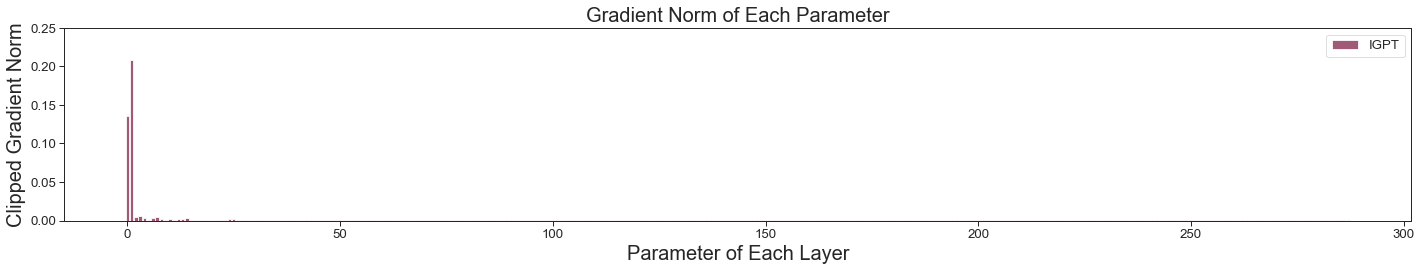

In [5]:
if model_name == 'gpt2':
    color = (0.372, 0.537, 0.537)
elif model_name == 'igpt':
    color = (0.627, 0.352, 0.470)
elif model_name == 'dt':
    color = (0.733, 0.737, 0.870)
else:
    color = None
plt.figure(figsize=(20, 4))
plt.bar(x=range(len(grad_norm)), height=list(grad_norm.values()), color=color, label=model_name.upper())
# plt.xticks([], [])
plt.xlabel('Parameter of Each Layer', fontsize=20)
plt.ylabel('Clipped Gradient Norm', fontsize=20)
plt.title('Gradient Norm of Each Parameter', fontsize=20)
plt.ylim(0, 0.25)
plt.legend()
plt.tight_layout()
plt.savefig(f'figs/gradnorm_perparam_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

In [8]:
df = pd.DataFrame([grad_norm]).astype(float)
df

,0.ln_1.weight,0.ln_1.bias,0.attn.c_attn.weight,0.attn.c_attn.bias,0.attn.c_proj.weight,0.attn.c_proj.bias,0.ln_2.weight,0.ln_2.bias,0.mlp.c_fc.weight,0.mlp.c_fc.bias,...,23.attn.c_attn.weight,23.attn.c_attn.bias,23.attn.c_proj.weight,23.attn.c_proj.bias,23.ln_2.weight,23.ln_2.bias,23.mlp.c_fc.weight,23.mlp.c_fc.bias,23.mlp.c_proj.weight,23.mlp.c_proj.bias
0,0.125104,0.214955,0.003636,0.004213,0.002127,0.000291,0.001898,0.005484,0.001112,0.000208,...,3.666996e-08,4.260053e-09,3.472765e-08,6.116364e-10,8.891388e-08,2.054207e-07,5.484305e-08,8.941743e-09,8.648243e-08,5.898039e-10


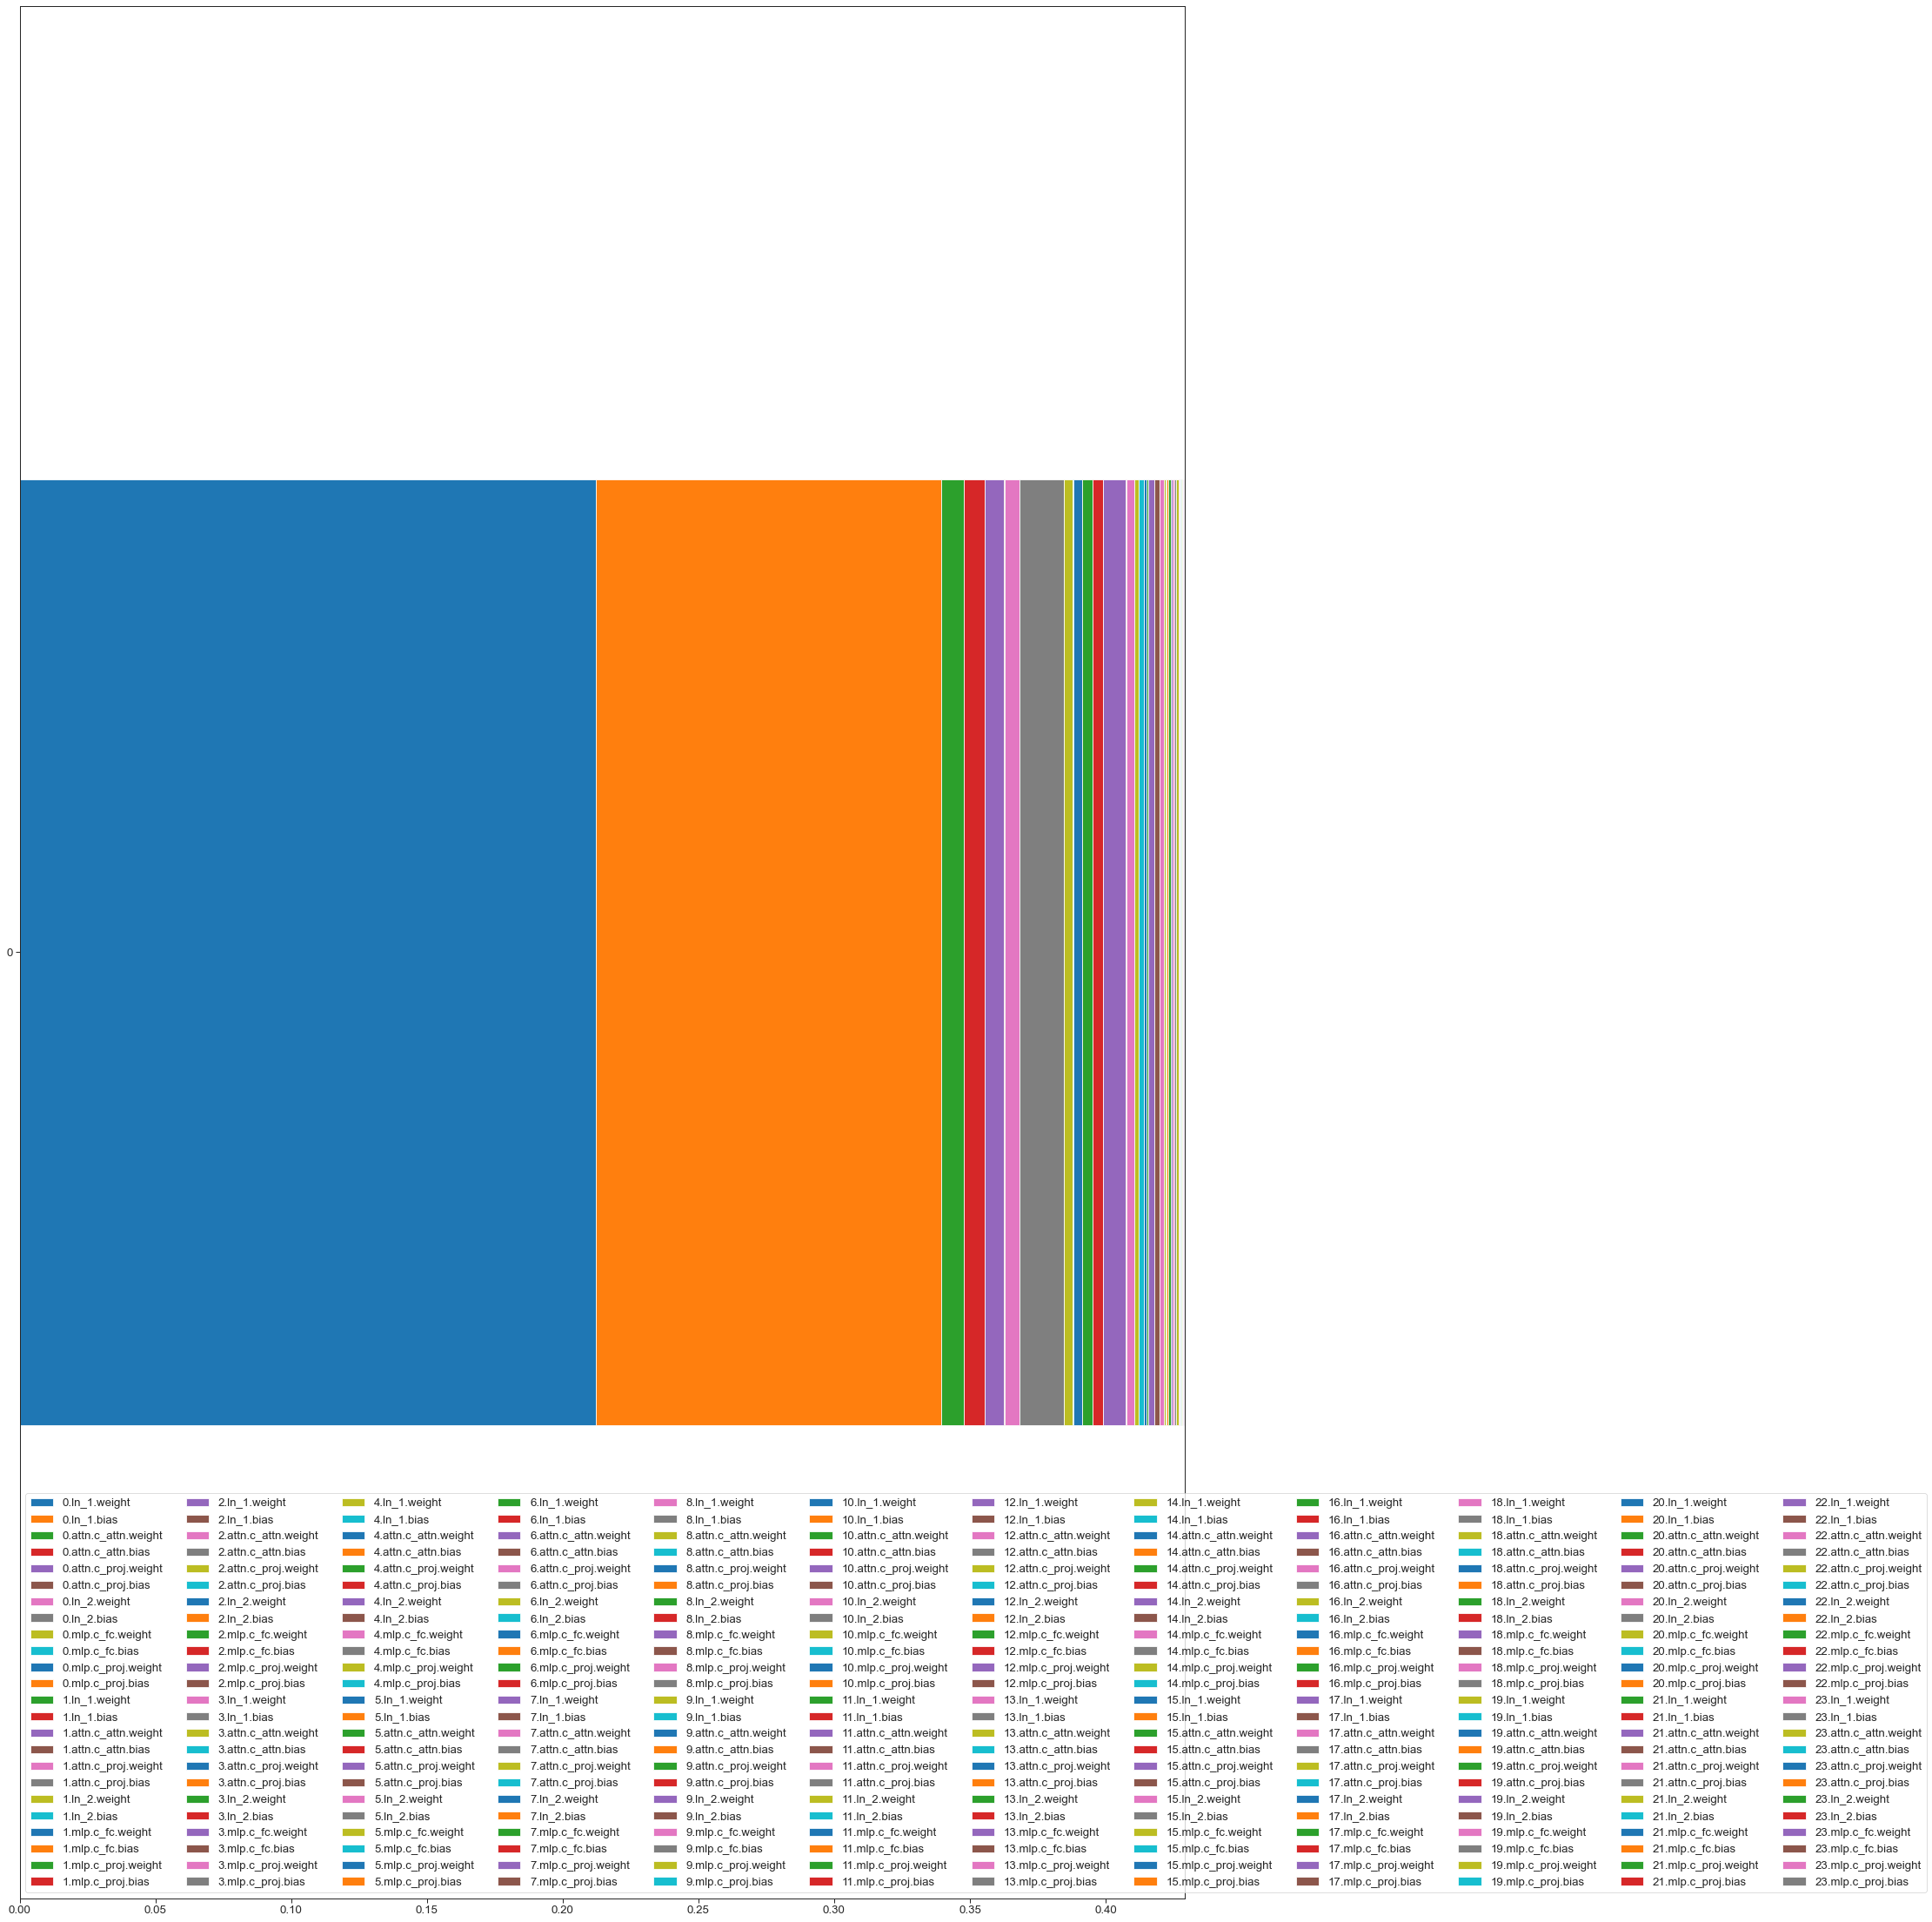

In [25]:
df = pd.DataFrame([grad_norm]).astype(float)
x = np.linspace(0, 1, len(grad_norm))#[(i+1)/len(grad_norm) for i in range(len(grad_norm))]
df.plot.barh(stacked=True, figsize=(24, 40))  # color=plt.cm.Blues_r(x), 
plt.legend(loc="lower left", ncol=12)
plt.show()

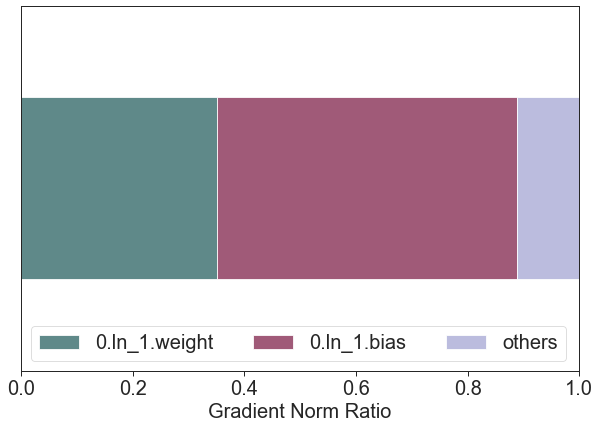

In [24]:
# plt.figure(figsize=(6.4, 4.8))

grad_norm_others = {
    '0.ln_1.weight': 0,
    '0.ln_1.bias': 0,
    'others': 0
}
total = np.sum(list(grad_norm.values()))
for key, value in grad_norm.items():
    if key == '0.ln_1.weight' or key == '0.ln_1.bias':
        grad_norm_others[key] = value / total
    else:
        grad_norm_others['others'] += value / total

total = np.sum(grad_norm_others.values())


df_others = pd.DataFrame([grad_norm_others]).astype(float)
x = np.linspace(0, 1, len(grad_norm_others))#[(i+1)/len(grad_norm) for i in range(len(grad_norm))]
df_others.plot.barh(stacked=True, figsize=(10, 6.7), color=[(0.372, 0.537, 0.537), (0.627, 0.352, 0.470), (0.733, 0.737, 0.870)], fontsize=20)  # color=plt.cm.Blues_r(x), 
plt.yticks([], [])
plt.xlim(0, 1)
# plt.title('Gradient Norm per Parameter', fontsize=12)
plt.xlabel('Gradient Norm Ratio', fontsize=20)
plt.legend(loc="lower left", ncol=12, fontsize=20)
plt.savefig(f'figs/gradnorm_perparam_ratio_{epoch}_igpt_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
plt.show()

In [19]:
10/6.4 * 4.8

7.5

In [83]:
grad_norm_others

{'0.ln_1.weight': array(0.15052631, dtype=float32),
 '0.ln_1.bias': array(0.19695084, dtype=float32),
 'others': 0.05460753018395437}

In [80]:
grad_norm

{'0.ln_1.weight': array(0.15052631, dtype=float32),
 '0.ln_1.bias': array(0.19695084, dtype=float32),
 '0.attn.c_attn.weight': array(0.00355266, dtype=float32),
 '0.attn.c_attn.bias': array(0.00384979, dtype=float32),
 '0.attn.c_proj.weight': array(0.00202323, dtype=float32),
 '0.attn.c_proj.bias': array(0.00023447, dtype=float32),
 '0.ln_2.weight': array(0.00244699, dtype=float32),
 '0.ln_2.bias': array(0.00378013, dtype=float32),
 '0.mlp.c_fc.weight': array(0.00086475, dtype=float32),
 '0.mlp.c_fc.bias': array(0.0001842, dtype=float32),
 '0.mlp.c_proj.weight': array(0.00097358, dtype=float32),
 '0.mlp.c_proj.bias': array(9.543335e-06, dtype=float32),
 '1.ln_1.weight': array(0.00104625, dtype=float32),
 '1.ln_1.bias': array(0.00136496, dtype=float32),
 '1.attn.c_attn.weight': array(0.00169627, dtype=float32),
 '1.attn.c_attn.bias': array(9.057235e-05, dtype=float32),
 '1.attn.c_proj.weight': array(0.00166962, dtype=float32),
 '1.attn.c_proj.bias': array(3.947326e-06, dtype=float32),
 

In [54]:
df['0.ln_1.weight']

0    0.15052631
Name: 0.ln_1.weight, dtype: object